In [20]:
#need to use python version 3.8 with conda as that's the requirement for maxfuse
import numpy as np
import pandas as pd
from scipy.io import mmread

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import anndata as ad
import scanpy as sc
import maxfuse as mf

import seaborn as sns

In [21]:
# this cell only needs to be run once
# import requests, zipfile, io
# r = requests.get("http://stat.wharton.upenn.edu/~zongming/maxfuse/data.zip")
# z = zipfile.ZipFile(io.BytesIO(r.content))
# z.extractall("../")

In [22]:
protein = pd.read_csv("data/tonsil/tonsil_codex.csv") # ~178,000 codex cells


<Axes: xlabel='centroid_x', ylabel='centroid_y'>

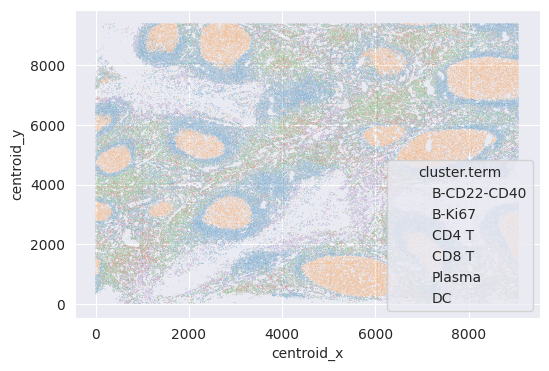

In [23]:
# not needed to run maxfuse
sns.scatterplot(data=protein, x="centroid_x", y="centroid_y", hue = "cluster.term", s = 0.1)


In [24]:
# input csv contains meta info, take only protein features
protein_features = ['CD38', 'CD19', 'CD31', 'Vimentin', 'CD22', 'Ki67', 'CD8',
       'CD90', 'CD123', 'CD15', 'CD3', 'CD152', 'CD21', 'cytokeratin', 'CD2',
       'CD66', 'collagen IV', 'CD81', 'HLA-DR', 'CD57', 'CD4', 'CD7', 'CD278',
       'podoplanin', 'CD45RA', 'CD34', 'CD54', 'CD9', 'IGM', 'CD117', 'CD56',
       'CD279', 'CD45', 'CD49f', 'CD5', 'CD16', 'CD63', 'CD11b', 'CD1c',
       'CD40', 'CD274', 'CD27', 'CD104', 'CD273', 'FAPalpha', 'Ecadherin']
# convert to AnnData
protein_adata = ad.AnnData(
    protein[protein_features].to_numpy(), dtype=np.float32
)
protein_adata.var_names = protein[protein_features].columns

In [25]:

# read in RNA data
rna = mmread("data/tonsil/tonsil_rna_counts.txt") # rna count as sparse matrix, 10k cells (RNA)
rna_names = pd.read_csv('data/tonsil/tonsil_rna_names.csv')['names'].to_numpy()
# convert to AnnData
rna_adata = ad.AnnData(
    rna.tocsr(), dtype=np.float32
)
rna_adata.var_names = rna_names

In [ ]:
rna_adata

In [26]:

# read in celltyle labels
metadata_rna = pd.read_csv('data/tonsil/tonsil_rna_meta.csv')
labels_rna = metadata_rna['cluster.info'].to_numpy()
labels_codex = protein['cluster.term'].to_numpy()

protein_adata.obs['celltype'] = labels_codex
rna_adata.obs['celltype'] = labels_rna

In [27]:

correspondence = pd.read_csv('data/protein_gene_conversion.csv')
correspondence.head()

,Protein name,RNA name
0,CD80,CD80
1,CD86,CD86
2,CD274,CD274
3,CD273,PDCD1LG2
4,CD275,ICOSLG


In [28]:
rna_protein_correspondence = []

for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in protein_adata.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in rna_adata.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])
            
rna_protein_correspondence = np.array(rna_protein_correspondence)

In [ ]:
rna_shared

In [29]:
# Columns rna_shared and protein_shared are matched.
# One may encounter "Variable names are not unique" warning,
# this is fine and is because one RNA may encode multiple proteins and vice versa.
rna_shared = rna_adata[:, rna_protein_correspondence[:, 0]].copy()
protein_shared = protein_adata[:, rna_protein_correspondence[:, 1]].copy()

/home/barroz/miniconda3/envs/maxfuse/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/barroz/miniconda3/envs/maxfuse/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [30]:
# Make sure no column is static, only use protein features
# that are variable (larger than a certain threshold)
mask = (
    (rna_shared.X.toarray().std(axis=0) > 0.5) 
    & (protein_shared.X.std(axis=0) > 0.1)
)
rna_shared = rna_shared[:, mask].copy()
protein_shared = protein_shared[:, mask].copy()
print([rna_shared.shape,protein_shared.shape])

[(12977, 32), (178919, 32)]


/home/barroz/miniconda3/envs/maxfuse/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/barroz/miniconda3/envs/maxfuse/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [31]:
# process rna_shared
sc.pp.normalize_total(rna_shared)
sc.pp.log1p(rna_shared)
sc.pp.scale(rna_shared)

/home/barroz/miniconda3/envs/maxfuse/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


/home/barroz/miniconda3/envs/maxfuse/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


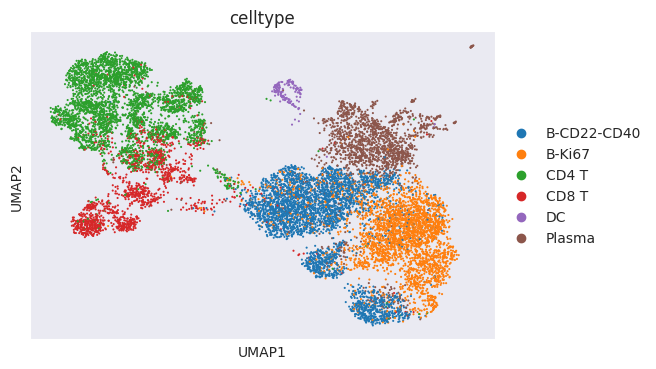

In [32]:

# plot UMAP of rna cells based only on rna markers with protein correspondence

sc.pp.neighbors(rna_shared, n_neighbors=15)
sc.tl.umap(rna_shared)
sc.pl.umap(rna_shared, color='celltype')

/home/barroz/miniconda3/envs/maxfuse/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


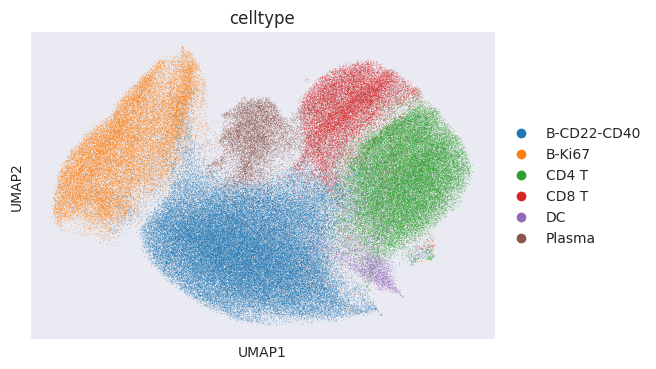

In [33]:

# plot UMAPs of codex cells based only on protein markers with rna correspondence
# due to a large number of codex cells, this can take a while. uncomment below to plot.

sc.pp.neighbors(protein_shared, n_neighbors=15)
sc.tl.umap(protein_shared)
sc.pl.umap(protein_shared, color='celltype')

In [34]:
rna_adata.X = rna_adata.X.toarray()
(rna_adata.X).std(axis=0)

array([0.        , 0.        , 0.        , ..., 0.26059663, 0.        ,
       0.00877772], dtype=float32)

In [35]:
# make sure no feature is static
rna_active = rna_adata.X
protein_active = protein_adata.X
rna_active = rna_active[:, rna_active.std(axis=0) > 1e-5] # these are fine since already using variable features
protein_active = protein_active[:, protein_active.std(axis=0) > 1e-5] # protein are generally variable

In [36]:
# inspect shape of the four matrices
print(rna_active.shape)
print(protein_active.shape)
print(rna_shared.shape)
print(protein_shared.shape)

(12977, 24304)
(178919, 46)
(12977, 32)
(178919, 32)


In [37]:
fusor = mf.model.Fusor(
    shared_arr1=rna_shared,
    shared_arr2=protein_shared,
    active_arr1=rna_active,
    active_arr2=protein_active,
    labels1=None,
    labels2=None
)

In [38]:
fusor.split_into_batches(
    max_outward_size=8000,
    matching_ratio=4,
    metacell_size=2,
    verbose=True
)

The first data is split into 1 batches, average batch size is 12977, and max batch size is 12977.
The second data is split into 5 batches, average batch size is 35783, and max batch size is 35787.
Batch to batch correspondence is:
  ['0<->0', '0<->1', '0<->2', '0<->3', '0<->4'].


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

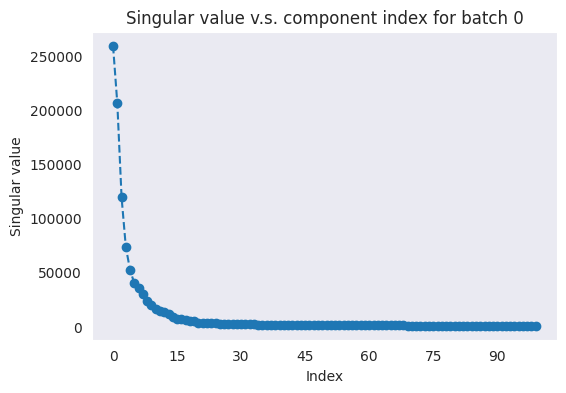

In [39]:
# plot top singular values of avtive_arr1 on a random batch
fusor.plot_singular_values(
    target='active_arr1',
    n_components=None # can also explicitly specify the number of components
)

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

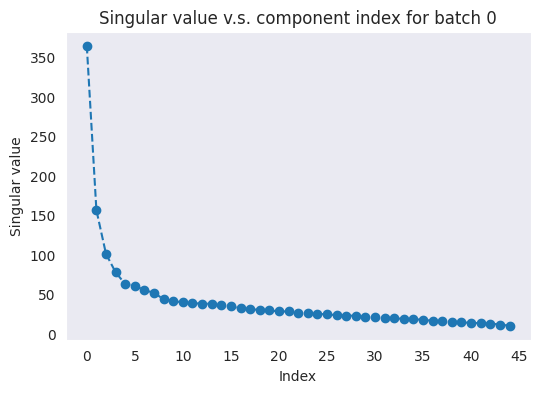

In [40]:
fusor.plot_singular_values(
    target='active_arr2',
    n_components=None
)

In [41]:
fusor.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=40,
    svd_components2=15,
    resolution1=2,
    resolution2=2,
    # if two resolutions differ less than resolution_tol
    # then we do not distinguish between then
    resolution_tol=0.1,
    verbose=True
)

Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr1...
Now at batch 0...
Graph clustering finished!
Constructing neighborhood graphs for cells in arr2...
Now at batch 0...
Now at batch 1...
Now at batch 2...
Now at batch 3...
Now at batch 4...
Graph construction finished!
Clustering the graphs for cells in arr2...
Now at batch 0...
Now at batch 1...
Now at batch 2...
Now at batch 3...
Now at batch 4...
Graph clustering finished!


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index'}, xlabel='Index', ylabel='Singular value'>)

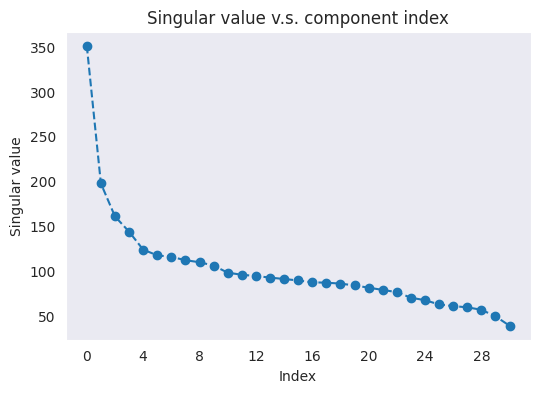

In [47]:
# step II: finding intitial pivots
fusor.shared_arr1 = fusor.shared_arr1.X  # Ensure it's a NumPy array
fusor.shared_arr2 = fusor.shared_arr2.X  # Ensure it's a NumPy array

fusor.plot_singular_values(
    target='shared_arr1',
    n_components=None,
)


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index'}, xlabel='Index', ylabel='Singular value'>)

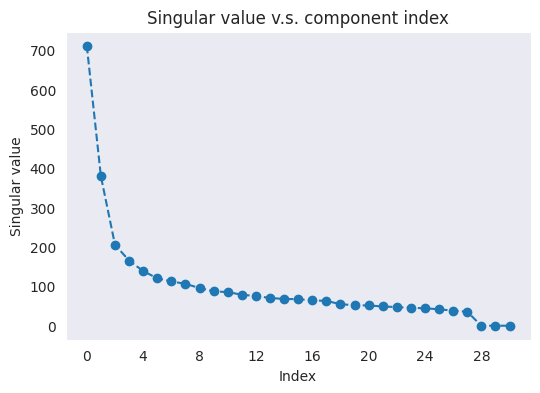

In [46]:
fusor.plot_singular_values(
    target='shared_arr2',
    n_components=None
)

In [51]:
fusor.find_initial_pivots(
    wt1=0.3, wt2=0.3,
    svd_components1=25, svd_components2=20
)


Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Done!


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Canonical correlation v.s. component index for batch 0<->1'}, xlabel='Index', ylabel='Canonical correlation'>)

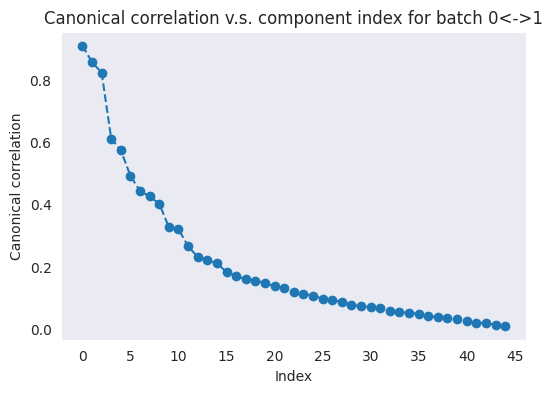

In [52]:

# plot top canonical correlations in a random batch
fusor.plot_canonical_correlations(
    svd_components1=50,
    svd_components2=None,
    cca_components=45
)


In [53]:
fusor.refine_pivots(
    wt1=0.3, wt2=0.3,
    svd_components1=40, svd_components2=None,
    cca_components=25,
    n_iters=1,
    randomized_svd=False, 
    svd_runs=1,
    verbose=True
)

Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Done!


In [54]:
fusor.filter_bad_matches(target='pivot', filter_prop=0.5)


Begin filtering...
Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
16235/32465 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
8344/12977 cells in arr1 are selected as pivots.
16235/178919 cells in arr2 are selected as pivots.
Done!


In [55]:
pivot_matching = fusor.get_matching(order=(2, 1),target='pivot')

lv1_acc = mf.metrics.get_matching_acc(matching=pivot_matching, 
    labels1=labels_rna, 
    labels2=labels_codex,
    order = (2,1)
)
lv1_acc

0.9009547274407145

In [57]:
# Assuming 'fusor' is your Fusor object
rna_cca, codex_cca = fusor.get_embedding(
    active_arr1=fusor.active_arr1,      # scRNA-seq active array
    active_arr2=fusor.active_arr2       # CODEX active array
)
